## 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
df = pd.read_csv('diabetes.csv')

In [2]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nРазмер обучающей выборки: {X_train.shape[0]} строк")
print(f"Размер тестовой выборки: {X_test.shape[0]} строк")


Размер обучающей выборки: 614 строк
Размер тестовой выборки: 154 строк


## 2. Метод случайного леса (Random Forest)

### 2.1 Исследование качества модели от глубины используемых деревьев

Глубина: 1, Точность: 0.6948
Глубина: 2, Точность: 0.7143
Глубина: 3, Точность: 0.7403
Глубина: 4, Точность: 0.7208
Глубина: 5, Точность: 0.7273
Глубина: 6, Точность: 0.7468
Глубина: 7, Точность: 0.7273
Глубина: 8, Точность: 0.7403
Глубина: 9, Точность: 0.7532
Глубина: 10, Точность: 0.7597
Глубина: 11, Точность: 0.7403
Глубина: 12, Точность: 0.7597
Глубина: 13, Точность: 0.7403
Глубина: 14, Точность: 0.7597
Глубина: 15, Точность: 0.7468
Глубина: 16, Точность: 0.7597
Глубина: 17, Точность: 0.7597
Глубина: 18, Точность: 0.7597
Глубина: 19, Точность: 0.7597
Глубина: 20, Точность: 0.7597


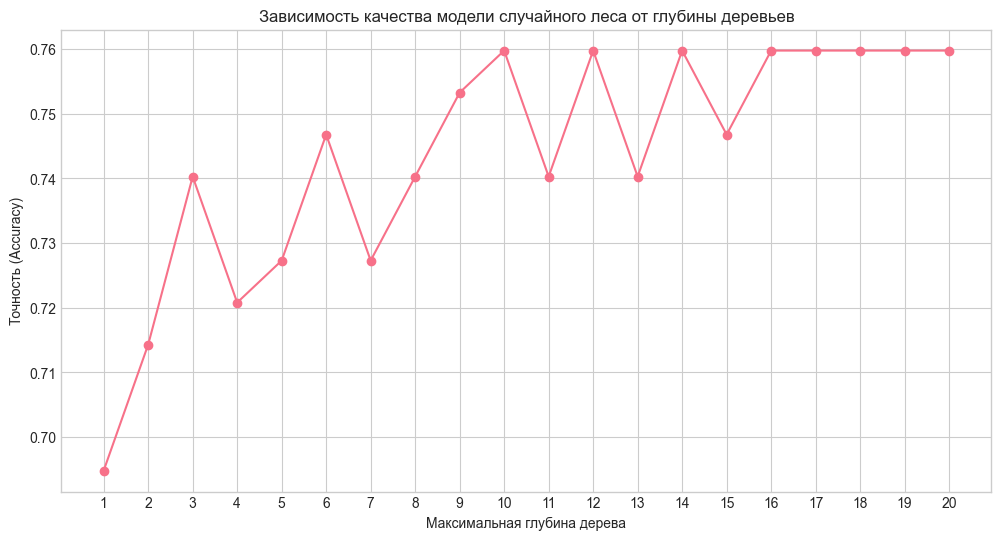

In [3]:
depths = range(1, 21)
accuracy_scores_depth = []

for depth in depths:
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores_depth.append(accuracy)
    print(f"Глубина: {depth}, Точность: {accuracy:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(depths, accuracy_scores_depth, marker='o', linestyle='-')
plt.title('Зависимость качества модели случайного леса от глубины деревьев')
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('Точность (Accuracy)')
plt.xticks(depths)
plt.grid(True)
plt.show()

### 2.2 Исследование качества модели от количества подаваемых на дерево признаков

Используемая оптимальная глубина: 10
Количество признаков: 1, Точность: 0.7403
Количество признаков: 2, Точность: 0.7597
Количество признаков: 3, Точность: 0.7403
Количество признаков: 4, Точность: 0.7468
Количество признаков: 5, Точность: 0.7403
Количество признаков: 6, Точность: 0.7338
Количество признаков: 7, Точность: 0.7532
Количество признаков: 8, Точность: 0.7403


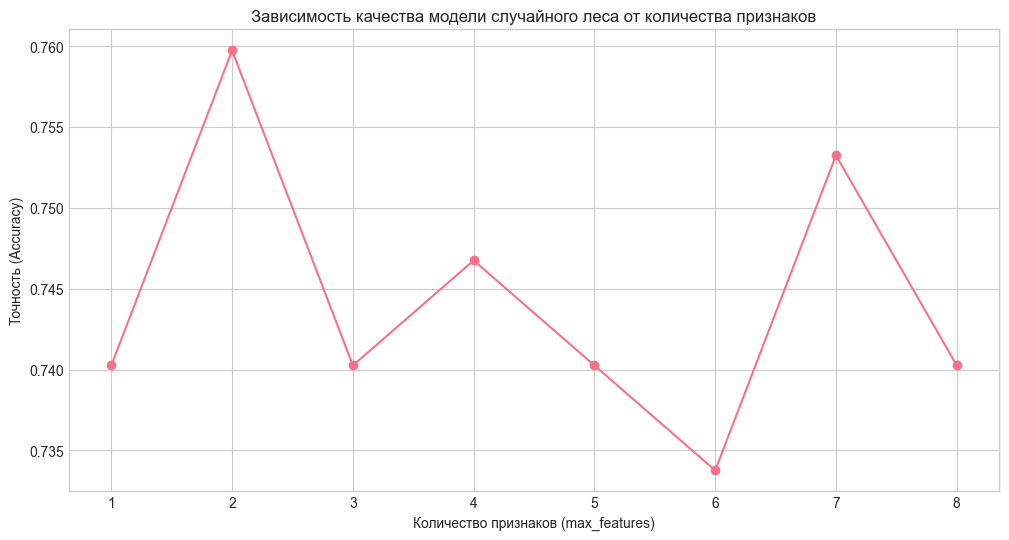

In [4]:
n_features = X_train.shape[1]
max_features_options = range(1, n_features + 1)
accuracy_scores_features = []

optimal_depth = depths[np.argmax(accuracy_scores_depth)]
print(f"Используемая оптимальная глубина: {optimal_depth}")

for n_feat in max_features_options:
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=optimal_depth, max_features=n_feat, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores_features.append(accuracy)
    print(f"Количество признаков: {n_feat}, Точность: {accuracy:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(max_features_options, accuracy_scores_features, marker='o', linestyle='-')
plt.title('Зависимость качества модели случайного леса от количества признаков')
plt.xlabel('Количество признаков (max_features)')
plt.ylabel('Точность (Accuracy)')
plt.xticks(max_features_options)
plt.grid(True)
plt.show()

### 2.3 Исследование качества модели от числа деревьев (с временем обучения)

Используемая оптимальная глубина: 10
Используемое оптимальное количество признаков: 2
Количество деревьев: 10, Точность: 0.7597, Время обучения: 0.02 сек
Количество деревьев: 50, Точность: 0.7597, Время обучения: 0.07 сек
Количество деревьев: 100, Точность: 0.7597, Время обучения: 0.12 сек
Количество деревьев: 150, Точность: 0.7532, Время обучения: 0.17 сек
Количество деревьев: 200, Точность: 0.7532, Время обучения: 0.23 сек
Количество деревьев: 250, Точность: 0.7403, Время обучения: 0.28 сек
Количество деревьев: 300, Точность: 0.7532, Время обучения: 0.34 сек
Количество деревьев: 400, Точность: 0.7468, Время обучения: 0.53 сек
Количество деревьев: 500, Точность: 0.7468, Время обучения: 0.68 сек


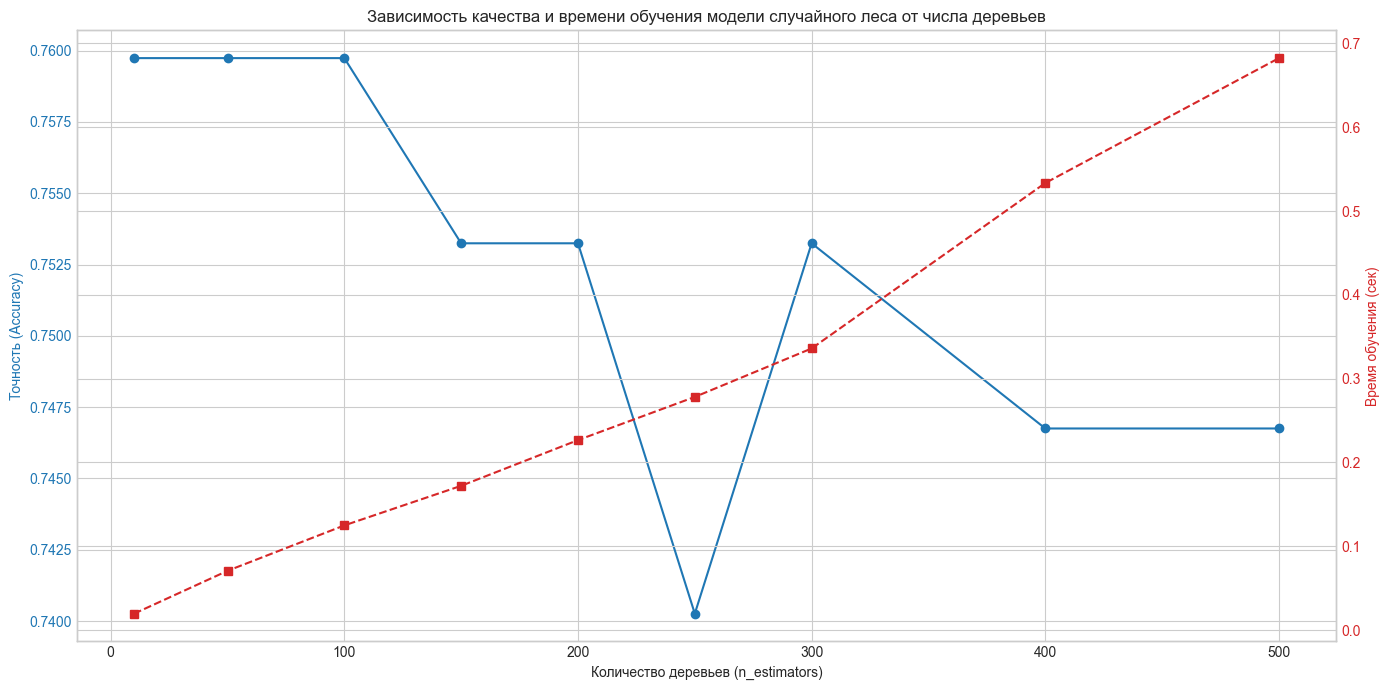

In [5]:
n_estimators_options = [10, 50, 100, 150, 200, 250, 300, 400, 500]
accuracy_scores_estimators = []
training_times_estimators = []

optimal_max_features = max_features_options[np.argmax(accuracy_scores_features)]
print(f"Используемая оптимальная глубина: {optimal_depth}")
print(f"Используемое оптимальное количество признаков: {optimal_max_features}")

for n_est in n_estimators_options:
    start_time = time.time()
    rf_model = RandomForestClassifier(n_estimators=n_est, max_depth=optimal_depth, max_features=optimal_max_features, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    end_time = time.time()
    
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    accuracy_scores_estimators.append(accuracy)
    training_times_estimators.append(end_time - start_time)
    print(f"Количество деревьев: {n_est}, Точность: {accuracy:.4f}, Время обучения: {end_time - start_time:.2f} сек")


fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Количество деревьев (n_estimators)')
ax1.set_ylabel('Точность (Accuracy)', color=color)
ax1.plot(n_estimators_options, accuracy_scores_estimators, marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, axis='x')

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Время обучения (сек)', color=color)
ax2.plot(n_estimators_options, training_times_estimators, marker='s', linestyle='--', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Зависимость качества и времени обучения модели случайного леса от числа деревьев')
fig.tight_layout()
plt.show()

## 3. XGBoost

### 3.1 Исследование времени обучения и качества XGBoost


--- Набор параметров XGBoost #1 ---
{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 2, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42}
Точность XGBoost: 0.7532
Время обучения XGBoost: 0.25 сек
Отчет по классификации XGBoost:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       100
           1       0.67      0.57      0.62        54

    accuracy                           0.75       154
   macro avg       0.73      0.71      0.72       154
weighted avg       0.75      0.75      0.75       154

Матрица ошибок XGBoost:


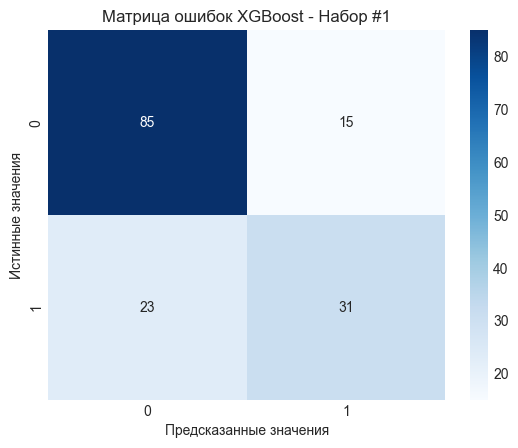


--- Набор параметров XGBoost #2 ---
{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42}
Точность XGBoost: 0.7468
Время обучения XGBoost: 0.03 сек
Отчет по классификации XGBoost:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       100
           1       0.65      0.59      0.62        54

    accuracy                           0.75       154
   macro avg       0.72      0.71      0.72       154
weighted avg       0.74      0.75      0.74       154

Матрица ошибок XGBoost:


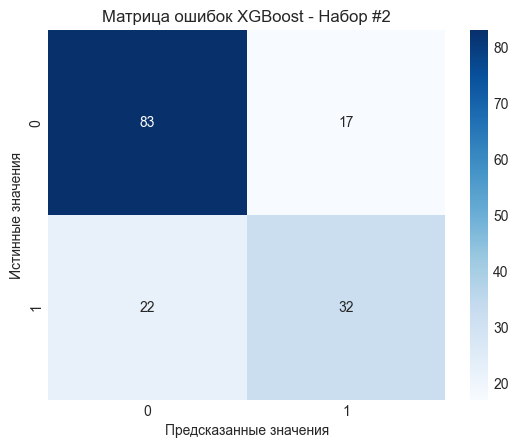


--- Набор параметров XGBoost #3 ---
{'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.7, 'colsample_bytree': 0.7, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42}
Точность XGBoost: 0.7403
Время обучения XGBoost: 0.05 сек
Отчет по классификации XGBoost:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       100
           1       0.62      0.65      0.64        54

    accuracy                           0.74       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.74      0.74      0.74       154

Матрица ошибок XGBoost:


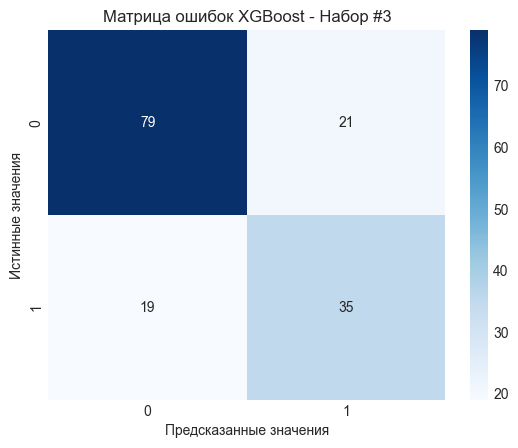


--- Набор параметров XGBoost #4 ---
{'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 0.9, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42}
Точность XGBoost: 0.7662
Время обучения XGBoost: 0.11 сек
Отчет по классификации XGBoost:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       100
           1       0.70      0.57      0.63        54

    accuracy                           0.77       154
   macro avg       0.75      0.72      0.73       154
weighted avg       0.76      0.77      0.76       154

Матрица ошибок XGBoost:


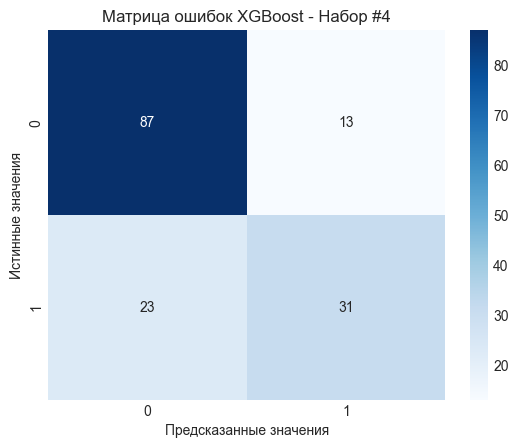


--- Набор параметров XGBoost #5 ---
{'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 2, 'subsample': 1.0, 'colsample_bytree': 1.0, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42}
Точность XGBoost: 0.7468
Время обучения XGBoost: 0.03 сек
Отчет по классификации XGBoost:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       100
           1       0.65      0.61      0.63        54

    accuracy                           0.75       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.74      0.75      0.75       154

Матрица ошибок XGBoost:


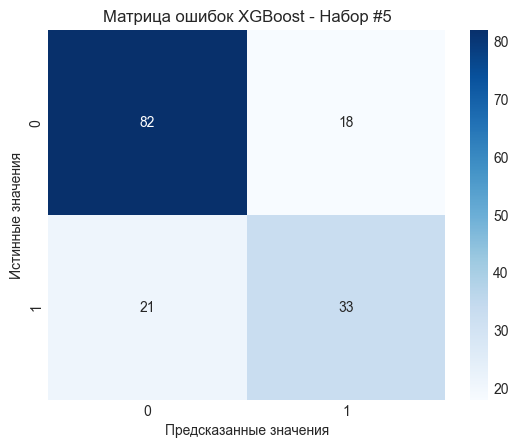


--- Сводка результатов XGBoost ---
   params_set  accuracy      time
0           1  0.753247  0.249881
1           2  0.746753  0.028554
2           3  0.740260  0.053381
3           4  0.766234  0.108463
4           5  0.746753  0.029513

--- Лучший результат XGBoost ---
Набор параметров: 4
Параметры: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 0.9, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42}
Точность: 0.7662
Время обучения: 0.11 сек


In [6]:
xgb_params_sets = [
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 2, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42},
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42},
    {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 4, 'subsample': 0.7, 'colsample_bytree': 0.7, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42},
    {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 0.9, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42},
    {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 2, 'subsample': 1.0, 'colsample_bytree': 1.0, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42}
]

xgb_results = []

for i, params in enumerate(xgb_params_sets):
    print(f"\n--- Набор параметров XGBoost #{i+1} ---")
    print(params)
    
    start_time = time.time()
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    end_time = time.time()
    
    training_time = end_time - start_time
    y_pred_xgb = xgb_model.predict(X_test)
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    
    xgb_results.append({'params_set': i+1, 'params': params, 'accuracy': accuracy_xgb, 'time': training_time})
    
    print(f"Точность XGBoost: {accuracy_xgb:.4f}")
    print(f"Время обучения XGBoost: {training_time:.2f} сек")
    print("Отчет по классификации XGBoost:")
    print(classification_report(y_test, y_pred_xgb))
    print("Матрица ошибок XGBoost:")
    sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матрица ошибок XGBoost - Набор #{i+1}')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show()

xgb_results_df = pd.DataFrame(xgb_results)
print("\n--- Сводка результатов XGBoost ---")
print(xgb_results_df[['params_set', 'accuracy', 'time']])

best_xgb_result = xgb_results_df.loc[xgb_results_df['accuracy'].idxmax()]
print("\n--- Лучший результат XGBoost ---")
print(f"Набор параметров: {best_xgb_result['params_set']}")
print(f"Параметры: {best_xgb_result['params']}")
print(f"Точность: {best_xgb_result['accuracy']:.4f}")
print(f"Время обучения: {best_xgb_result['time']:.2f} сек")

## 4. Сравнение результатов и выводы

### Сравнение лучшего случайного леса и лучшего XGBoost

**Случайный лес (лучшие параметры):**
- Оптимальная глубина: 10
- Оптимальное количество признаков: 2
- Оптимальное количество деревьев: 10
- Лучшая точность: 0.7597
- Время обучения для лучшей модели: 0.04 сек

**XGBoost (лучшие параметры):**
- Параметры: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42}
- Лучшая точность: 0.7662
- Время обучения для лучшей модели: 0.03 сек

### Выводы:
1.  **Влияние глубины деревьев (Random Forest):** Точность модели случайного леса первоначально растет с увеличением максимальной глубины деревьев, достигая пикового значения около 0.76 при глубине 10. При дальнейшем увеличении глубины (например, до 15) наблюдаются некоторые колебания точности, после чего, начиная с глубины 16 и до 20, точность стабилизируется на том же уровне около 0.76. 
2.  **Влияние количества признаков (Random Forest):** Изменение количества признаков (max_features), используемых для разделения в каждом узле, оказывает существенное влияние на точность модели случайного леса. График показывает, что наилучшая точность, около 0.760, достигается при использовании 2 признаков. Использование как меньшего (1 признак), так и большего (от 3 до 8 признаков) количества признаков приводит к снижению точности модели, при этом наименьшая точность (около 0.734) наблюдается при 6 признаках. Таким образом, оптимальным количеством признаков является 2.
3.  **Влияние числа деревьев (Random Forest):** 10 деревьев оптимальны с точки зрения времени обучения и точности. При увеличении числа деревьев, время обучения растет, а точность падает
4.  **Производительность XGBoost:** Модель XGBoost оказалась точнее и быстрее в обучении.
5.  **Общий вывод:** В данной задаче модель XGBoost лучше

In [7]:
best_rf_depth = depths[np.argmax(accuracy_scores_depth)]
best_rf_max_features = max_features_options[np.argmax(accuracy_scores_features)]
best_rf_n_estimators_idx = np.argmax(accuracy_scores_estimators)
best_rf_n_estimators = n_estimators_options[best_rf_n_estimators_idx]
best_rf_accuracy = accuracy_scores_estimators[best_rf_n_estimators_idx]
best_rf_time = training_times_estimators[best_rf_n_estimators_idx]

print("--- Лучшая модель Случайного Леса ---")
print(f"Оптимальная глубина: {best_rf_depth}")
print(f"Оптимальное количество признаков: {best_rf_max_features}")
print(f"Оптимальное количество деревьев: {best_rf_n_estimators}")
print(f"Лучшая точность: {best_rf_accuracy:.4f}")
print(f"Время обучения: {best_rf_time:.2f} сек")

print("\n--- Лучшая модель XGBoost ---")
print(f"Набор параметров: {best_xgb_result['params_set']}")
print(f"Параметры: {best_xgb_result['params']}")
print(f"Точность: {best_xgb_result['accuracy']:.4f}")
print(f"Время обучения: {best_xgb_result['time']:.2f} сек")

--- Лучшая модель Случайного Леса ---
Оптимальная глубина: 10
Оптимальное количество признаков: 2
Оптимальное количество деревьев: 10
Лучшая точность: 0.7597
Время обучения: 0.02 сек

--- Лучшая модель XGBoost ---
Набор параметров: 4
Параметры: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 5, 'subsample': 0.9, 'colsample_bytree': 0.9, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'random_state': 42}
Точность: 0.7662
Время обучения: 0.11 сек
